In [1]:
!pip install beautifulsoup4


In [2]:
!pip install requests
!pip install pandas
!pip install matplotlib
!pip install nltk
!pip install textblob
!pip install wordcloud
!pip install seaborn

# WEB SCRAPPING

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os

In [13]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 50

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 50 total reviews
Scraping page 2
   ---> 100 total reviews
Scraping page 3
   ---> 150 total reviews
Scraping page 4
   ---> 200 total reviews
Scraping page 5
   ---> 250 total reviews
Scraping page 6
   ---> 300 total reviews
Scraping page 7
   ---> 350 total reviews
Scraping page 8
   ---> 400 total reviews
Scraping page 9
   ---> 450 total reviews
Scraping page 10
   ---> 500 total reviews


In [14]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | We started our day with BA ...
1,✅ Trip Verified | I fly British Airways weekl...
2,Not Verified | Everything was ok until our co...
3,Not Verified | My initial flight was cancelle...
4,Not Verified | We will never fly British Airw...


In [15]:
df.to_csv("data/BRITISHAIRWAYS_reviews.csv")

In [16]:
# Load the data
data_path = 'data/BRITISHAIRWAYS_reviews.csv'
df = pd.read_csv(data_path)

# Display the first few rows of the DataFrame
df.head()

,Unnamed: 0,reviews
0,0,✅ Trip Verified | We started our day with BA ...
1,1,✅ Trip Verified | I fly British Airways weekl...
2,2,Not Verified | Everything was ok until our co...
3,3,Not Verified | My initial flight was cancelle...
4,4,Not Verified | We will never fly British Airw...


In [9]:
# ensure the loaded data is clean and relevant for analysis
# Display basic information about the DataFrame
df.info()

# Check for duplicates
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

# Drop duplicates
df.drop_duplicates(inplace=True)

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

# Drop rows with missing values
df.dropna(inplace=True)

# Display basic statistics of the data
summary_stats = df.describe(include='all')
print("Summary Statistics:\n", summary_stats)

# Display the first few rows of the cleaned DataFrame
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  300 non-null    int64 
 1   reviews     300 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.8+ KB
Number of duplicate rows: 0
Missing values:
 Unnamed: 0    0
reviews       0
dtype: int64
Summary Statistics:
         Unnamed: 0                                            reviews
count   300.000000                                                300
unique         NaN                                                300
top            NaN  ✅ Trip Verified |  We started our day with BA ...
freq           NaN                                                  1
mean    149.500000                                                NaN
std      86.746758                                                NaN
min       0.000000                                                NaN
25%      74.750

,Unnamed: 0,reviews
0,0,✅ Trip Verified | We started our day with BA ...
1,1,✅ Trip Verified | I fly British Airways weekl...
2,2,Not Verified | Everything was ok until our co...
3,3,Not Verified | My initial flight was cancelle...
4,4,Not Verified | We will never fly British Airw...


In [17]:
# Extract the claim information from the 'reviews' column
df['claim'] = df['reviews'].str.extract(r'(\bTrip Verified\b|\bNot Verified\b)')

# Filter for Trip Verified and Not Verified claims
trip_verified_reviews = df[df['claim'] == 'Trip Verified']['reviews']
not_verified_reviews = df[df['claim'] == 'Not Verified']['reviews']

# Display the first few reviews for each category
print("Trip Verified Reviews:")
print(trip_verified_reviews.head())

print("\nNot Verified Reviews:")
print(not_verified_reviews.head())


Trip Verified Reviews:
0    ✅ Trip Verified |  We started our day with BA ...
1    ✅ Trip Verified |  I fly British Airways weekl...
5    ✅ Trip Verified | Check in and security cleara...
7    ✅ Trip Verified | Worst BA experience. I was s...
8    ✅ Trip Verified |  My daughter and I were deni...
Name: reviews, dtype: object

Not Verified Reviews:
2     Not Verified |  Everything was ok until our co...
3     Not Verified |  My initial flight was cancelle...
4     Not Verified |  We will never fly British Airw...
6     Not Verified |  British Airways has confirmed ...
10    Not Verified |  Flight cancelled, no crew! 9th...
Name: reviews, dtype: object


# Sentiment Analysis

In [18]:
# TextBlob
from textblob import TextBlob

# Function to get the sentiment polarity of a text
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

# Apply sentiment analysis to the 'reviews' column
df['sentiment'] = df['reviews'].apply(get_sentiment)

# Display the sentiment analysis results
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment Analysis Results:\n", sentiment_counts)


Sentiment Analysis Results:
 positive    297
negative    197
neutral       6
Name: sentiment, dtype: int64


In [19]:
# Calculate the percentage of positive sentiments (customer satisfaction)
positive_sentiment_percentage = (df['sentiment'].value_counts(normalize=True).get('positive', 0)) * 100

# Display the customer satisfaction assessment
print("Customer Satisfaction Assessment (Percentage of Positive Sentiments): {:.2f}%".format(positive_sentiment_percentage))


Customer Satisfaction Assessment (Percentage of Positive Sentiments): 59.40%


In [27]:
# Function to identify areas of improvement from negative reviews containing 'suggest' or 'would'
def identify_areas_of_improvement_suggest_would(negative_reviews):
    # Tokenize the negative reviews into sentences
    negative_sentences = [sent for review in negative_reviews for sent in nltk.sent_tokenize(review)]
    
    # Filter sentences that contain 'suggest' or 'would'
    improvement_sentences = [sentence for sentence in negative_sentences if 'suggest' in sentence.lower() or 'would' in sentence.lower()]
    return improvement_sentences

# Identify areas of improvement (sentences containing 'suggest' or 'would') from negative reviews
improvement_sentences_suggest_would = identify_areas_of_improvement_suggest_would(negative_reviews)

# Display the identified areas of improvement (sentences)
print("Areas of Improvement containing 'suggest' or 'would' from Negative Reviews:")
for i, sentence in enumerate(improvement_sentences_suggest_would, start=1):
    print(f"{i}. {sentence}\n")


Areas of Improvement containing 'suggest' or 'would' from Negative Reviews:
1. If I could give zero stars I would.

2. After engineers tried to fix it while we waited on the plane for over an hour we were finally told that we would have to be evacuated and rebooked for another flight but not to worry because a special crew was waiting for us on the ground to help us and set us up in a hotel except that there was no one to help us.

3. Anyone with a connecting flight couldn't rebook on the application because the app wouldn't disassociate our first flight with the connecting one in London and the staff saw this but still refused to help us.

4. I don't have the money to pay for this but after a 10 hour flight, 8 hours of jet lag and the insane stress after the fact that no one from British Airways would help us I took the room.

5. They did tell us that the BA departure to Heathrow had also been cancelled, meaning there would be no further BA flight from Frankfurt to London that day (al

In [31]:
# Function to summarize the identified areas of improvement
def summarize_areas_of_improvement(improvement_sentences):
    summarized_problems = []
    for sentence in improvement_sentences:
        # Tokenize each sentence into words
        words = nltk.word_tokenize(sentence)
        # Check for the presence of key words like 'suggest' or 'would'
        if any(word in ['suggest', 'would'] for word in words):
            # Extract the problem statement (from the keyword to the end of the sentence)
            keyword_index = min((words.index(word) for word in ['suggest', 'would'] if word in words), default=None)
            if keyword_index is not None:
                problem_statement = ' '.join(words[keyword_index:])
                summarized_problems.append(problem_statement)
    return summarized_problems

# Summarize the identified areas of improvement (problems)
summarized_problems = summarize_areas_of_improvement(improvement_sentences_suggest_would)

# Display the summarized problems
print("Summarized Problems based on Areas of Improvement:")
for i, problem in enumerate(summarized_problems, start=1):
    print(f"{i}. {problem}\n")


Summarized Problems based on Areas of Improvement:
1. would .

2. would have to be evacuated and rebooked for another flight but not to worry because a special crew was waiting for us on the ground to help us and set us up in a hotel except that there was no one to help us .

3. would n't disassociate our first flight with the connecting one in London and the staff saw this but still refused to help us .

4. would help us I took the room .

5. would be no further BA flight from Frankfurt to London that day ( although other airlines were still operating the route- but BA refused to rebook us on them ) .

6. would be no meals served .

7. would stick with another airline .

8. would mean climbing over a person on the aisle .

9. would make you hang up .

10. would think we should still make our flight , unfortunately long security lines caused over 1.5 hr further delay .

11. would reimburse occurred expenses .

12. would only reimburse toiletries .

13. would strongly advise avoiding th

In [37]:
# Function to categorize the summarized problems into booking, food, and service issues
def categorize_problems(summarized_problems):
    categorized_problems = {'Booking': [], 'Food': [], 'Service': []}

    # Keywords indicative of each category
    booking_keywords = ['booking', 'reservation', 'ticket']
    food_keywords = ['food', 'meal', 'catering']
    service_keywords = ['service', 'staff', 'crew']

    for problem in summarized_problems:
        # Convert the problem statement to lowercase for case-insensitive matching
        problem_lower = problem.lower()

        # Categorize the problem based on keywords
        if any(keyword in problem_lower for keyword in booking_keywords):
            categorized_problems['Booking'].append(problem)
        if any(keyword in problem_lower for keyword in food_keywords):
            categorized_problems['Food'].append(problem)
        if any(keyword in problem_lower for keyword in service_keywords):
            categorized_problems['Service'].append(problem)

    return categorized_problems

# Function to print in bold
def print_bold(text):
    print("\033[1m" + text + "\033[0m")

# Categorize the summarized problems
categorized_problems = categorize_problems(summarized_problems)

# Display the categorized problems with category titles in bold
for category, problems in categorized_problems.items():
    print_bold(f"\nCategory: {category}")
    for i, problem in enumerate(problems, start=1):
        print(f"{i}. {problem}\n")



Category: Booking
1. would rather pay more money for a ticket in a different airline than buy through this company again .

2. would enter the booking reference and the site would say it was a success and the booking would show up once I refreshed the page but it did not .

3. would do the same thing every time , say it was a success then never add the booking .

4. would have been able to make based on another flight out we found , causing us to have to buy much more expensive tickets home that resulted in us having an overnight layover and having to buy a hotel room on top of ridiculously expensive last minute tickets .


Category: Food
1. would be no meals served .

2. suggest that you bring your own food .


Category: Service
1. would have to be evacuated and rebooked for another flight but not to worry because a special crew was waiting for us on the ground to help us and set us up in a hotel except that there was no one to help us .

2. would n't disassociate our first flight wi

In [38]:
# Function to print a title in bold
def print_title(title):
    print("\n\033[1m" + title + "\033[0m")

# Display the title
print_title("Areas to Improve")

# Display the categorized problems with category titles in bold
for category, problems in categorized_problems.items():
    print_bold(f"\nCategory: {category}")
    for i, problem in enumerate(problems, start=1):
        print(f"{i}. {problem}\n")



Areas to Improve

Category: Booking
1. would rather pay more money for a ticket in a different airline than buy through this company again .

2. would enter the booking reference and the site would say it was a success and the booking would show up once I refreshed the page but it did not .

3. would do the same thing every time , say it was a success then never add the booking .

4. would have been able to make based on another flight out we found , causing us to have to buy much more expensive tickets home that resulted in us having an overnight layover and having to buy a hotel room on top of ridiculously expensive last minute tickets .


Category: Food
1. would be no meals served .

2. suggest that you bring your own food .


Category: Service
1. would have to be evacuated and rebooked for another flight but not to worry because a special crew was waiting for us on the ground to help us and set us up in a hotel except that there was no one to help us .

2. would n't disassociate o


Percentage Distribution of Problem Categories:
Booking: 33.33%
Food: 16.67%
Service: 50.00%


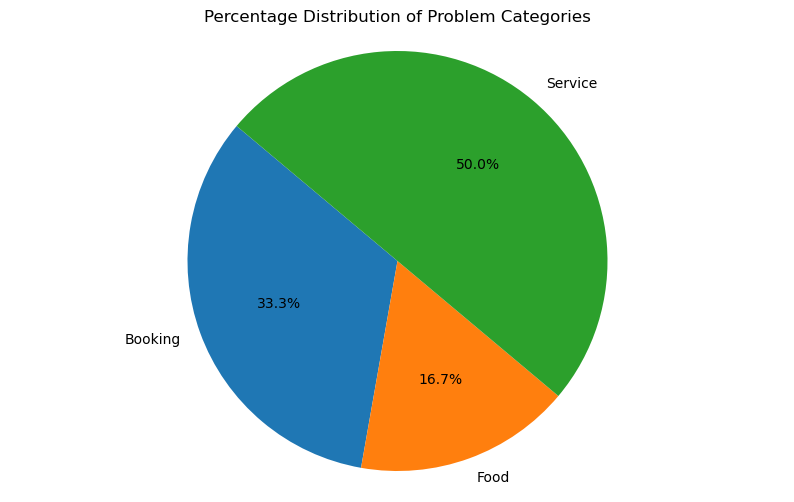

In [39]:
import matplotlib.pyplot as plt

# Function to create a pie chart
def create_pie_chart(categories, category_counts):
    plt.figure(figsize=(10, 6))
    plt.pie(category_counts, labels=categories, autopct='%1.1f%%', startangle=140)
    plt.title('Percentage Distribution of Problem Categories')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# Calculate the total number of problems for percentage calculation
total_problems = sum(len(problems) for problems in categorized_problems.values())

# Calculate the percentage for each category
category_percentages = {category: (len(problems) / total_problems) * 100 for category, problems in categorized_problems.items()}

# Display the percentage for each category
print("\nPercentage Distribution of Problem Categories:")
for category, percentage in category_percentages.items():
    print(f"{category}: {percentage:.2f}%")

# Create a pie chart for the percentage distribution
categories = list(categorized_problems.keys())
category_counts = [len(problems) for problems in categorized_problems.values()]
create_pie_chart(categories, category_counts)


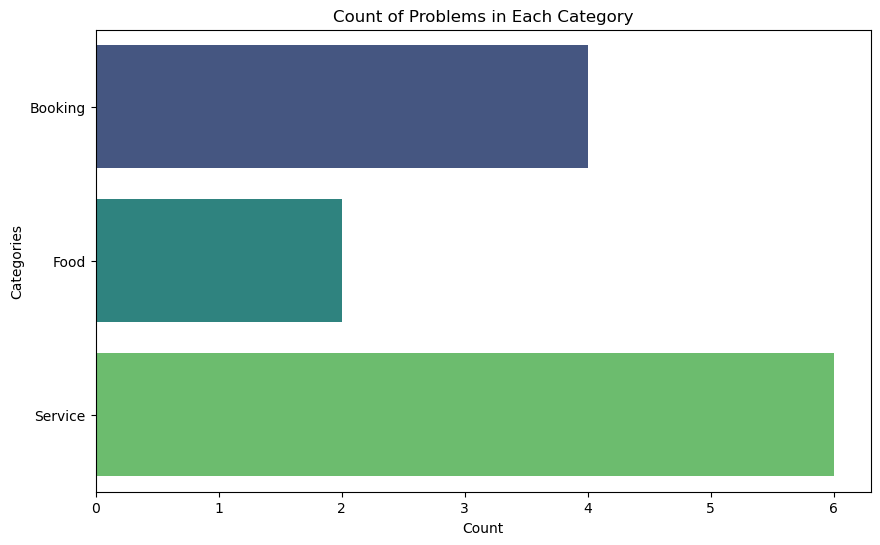

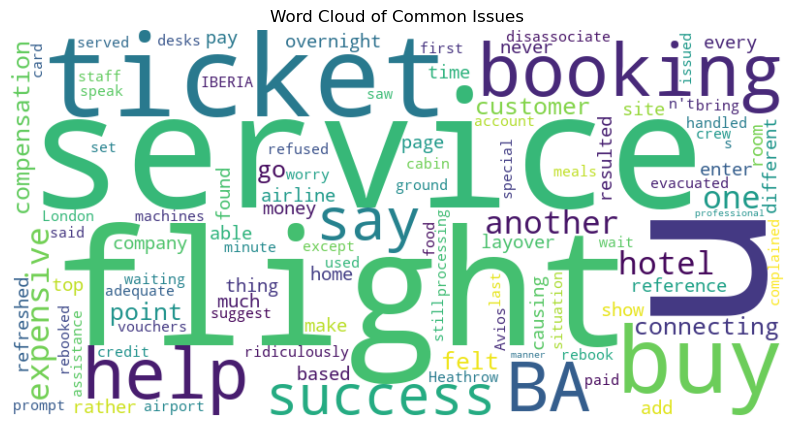

In [40]:
from wordcloud import WordCloud
import seaborn as sns

# Function to create a bar chart
def create_bar_chart(categories, category_counts):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_counts, y=categories, palette='viridis')
    plt.xlabel('Count')
    plt.ylabel('Categories')
    plt.title('Count of Problems in Each Category')
    plt.show()

# Function to create a word cloud
def create_word_cloud(problems):
    # Concatenate the problem statements for the word cloud
    text = ' '.join(problems)
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Common Issues')
    plt.show()

# Display the bar chart
create_bar_chart(categories, category_counts)

# Display the word cloud
all_problems = [problem for problems in categorized_problems.values() for problem in problems]
create_word_cloud(all_problems)
